# Machine Learning for Author Attribution 

## OVERVIEW

Author attribution "is the task of identifying the author of a given text from a (given) set of suspects (Mohsen et al. (2016))." This is a problem that can readily be framed as a text classification task, "where author represents a class (label) of a given text (Mohsen et al. (2016))," and as a result, recent research into author attribution analysis has focussed almost exclusively on the use of machine learning techniques.

Prior to the advent of social media, author attribution analysis was typically applied to longer texts, such as books and letters. In fact, Forsyth and Holmes (1996) concluded that a text had to be a minimum of 250 words in length for the stylometric characteristics to be apparent. However, recent research (for example, Green and Sheppard (2013), Schwartz et al. (2013) and Shrestha et al. (2017)) has demonstrated the successful application of author attribution techniques to Twitter messages ("tweets"), which "average less than 25 words" in length and are "often less than 10" words long (Green and Sheppard (2013)). 

Tweets are currently limited to 280 characters, and prior to November 2017, were limited to 140 characters. As a result, "tweets are relatively self-contained and have smaller sentence length variance compared to excerpts from longer text (Schwartz et al. (2013))." It is possible that these characteristics are the reason why author attribution techniques, that have previously fallen apart when applied to shorter texts, have succeeded when applied to tweets. It is also possible that, had Forsyth and Holmes (1996) considered more modern machine learning algorithms in their analysis, such as support vector machines (SVMs) and neural networks, which were not in common use in 1996, that they would have drawn different conclusions about the minimum text length required to successfully identify the author of a text. 

In this analysis we explore these hypotheses by applying techniques that have been demonstrated to succeed in determining the authorship of tweets, to short, tweet-length, excerpts of longer works. In performing this analysis, we make use of a dataset comprising 68,000 sentence-long excerpts from the (fiction) works of eight classic authors. 

The dataset was created using novel texts sourced from [Project Gutenburg](https://www.gutenberg.org/), with chapter/section headings manually removed from the files prior to processing. To allow for the creation of a balanced dataset, for authors whose novels tended to be shorter in length, text excerpts were taken from multiple works.

The novels used to create the dataset are attached in the folder for your reference:

### Import Packages and Load Data

In [1]:
import numpy as np
import pandas as pd
from keras.callbacks import ModelCheckpoint 
import nltk
nltk.download('punkt')
from nltk.corpus import stopwords
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
nltk.download('stopwords')
import time
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, make_scorer, confusion_matrix
from sklearn.metrics import precision_recall_fscore_support as score
from keras.models import Model
import chardet
from keras.layers import Input, Dense, Flatten, Dropout, Embedding
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers.merge import concatenate
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.text import one_hot
from nltk.stem.porter import PorterStemmer
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler
from sklearn.preprocessing import LabelBinarizer
from sklearn.svm import SVC
from scipy import sparse, stats
from nltk import tokenize
import numpy as np
import random
from sklearn.model_selection import train_test_split
from keras.models import Model
from keras import metrics
import tensorflow as tf
from keras.layers import Input, Dense, Embedding,Dropout,Conv1D,MaxPooling1D,Flatten,concatenate
def split_text(filepath, min_char):
    file = open(filepath, "r", encoding="utf8")
    text = file.read().replace('\n', ' ')
    text = text.replace('--', ' ').replace('. . .', '').replace('_', '')
    text = text.replace('.”', '”.').replace('."', '".').replace('?”', '”?').replace('!”', '”!')
    file.close()
    sentences = tokenize.sent_tokenize(text)
    sentences = [sent for sent in sentences if len(sent) >= min_char]
    return list(sentences)
min_char = 5
alcott = split_text('Books/Little_Women.txt', min_char = min_char)
stoker = split_text('Books/Dracula.txt', min_char = min_char)
twain = split_text('Books/Tom_Sawyer.txt', min_char = min_char)\
        + split_text('Books/Huckleberry_Finn.txt', min_char = min_char)
austen = split_text('Books/Pride_and_Prejudice.txt', min_char = min_char)\
         + split_text('Books/Emma.txt', min_char = min_char)
collins = split_text('Books/Woman_in_White.txt', min_char = min_char)
doyle = split_text('Books/Study_in_Scarlet.txt', min_char = min_char)\
        + split_text('Books/Sign_of_the_Four.txt', min_char = min_char)\
        + split_text('Books/Hound_of_the_Baskervilles.txt', min_char = min_char)
montgomery = split_text('Books/Anne_of_Green_Gables.txt', min_char = min_char)\
             + split_text('Books/Anne_of_Avonlea.txt', min_char = min_char)
bronte = split_text('Books/Jane_Eyre.txt', min_char = min_char)

text_dict = {'Alcott': alcott, 'Stoker': stoker, 'Twain': twain, 'Austen': austen, 'Collins': collins,
             'Doyle': doyle, 'Montgomery': montgomery, 'Bronte': bronte }
np.random.seed(1)
combined = []
max_length = 8500
names = [alcott, stoker,twain, austen, collins, doyle, montgomery, bronte]
for name in names:
    name = np.random.choice(name, max_length, replace = False)
    combined += list(name)

print('Length of the combined list is ', len(combined))

[nltk_data] Downloading package punkt to C:\Users\My
[nltk_data]     Pc\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\My
[nltk_data]     Pc\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Length of the combined list is  68000


In [2]:
labels = ['Alcott']*max_length + ['Stoker']*max_length + ['Twain']*max_length + ['Austen']*max_length\
         + ['Collins']*max_length + ['Doyle']*max_length + ['Montgomery']*max_length + ['Bronte']*max_length
random.seed(3)
zipped = list(zip(combined, labels))
random.shuffle(zipped)
combined, labels = zip(*zipped)
out_data = pd.DataFrame()
out_data['text'] = combined
out_data['author'] = labels
out_data.to_csv('author_data.csv', index=False)
# Get encoding of data file
with open("C:/Users/My Pc/Desktop/Python/Ashwin Github/N16317183/author_data.csv", 'rb') as file:
    print(chardet.detect(file.read()))
data = pd.read_csv("C:/Users/My Pc/Desktop/Python/Ashwin Github/N16317183/author_data.csv", encoding="utf-8")

{'encoding': 'utf-8', 'confidence': 0.99, 'language': ''}


C:\Users\My Pc\AppData\Roaming\Python\Python39\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artist

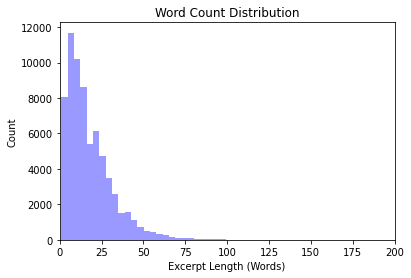

In [3]:
# Create word count and character count lists
text = list(data['text'].values)
author = list(data['author'].values)
word_count = []
char_count = []

for i in range(len(text)):
    word_count.append(len(text[i].split()))
    char_count.append(len(text[i]))

# Convert lists to numpy arrays
word_count = np.array(word_count)
char_count = np.array(char_count)

# Calculate average word lengths
ave_length = np.array(char_count)/np.array(word_count)
sns.distplot(word_count, kde = False, bins = 70, color = 'blue').set_title("Word Count Distribution")
plt.xlabel('Excerpt Length (Words)')
plt.ylabel('Count')
plt.xlim(0, 200)
plt.savefig("word_count.eps")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

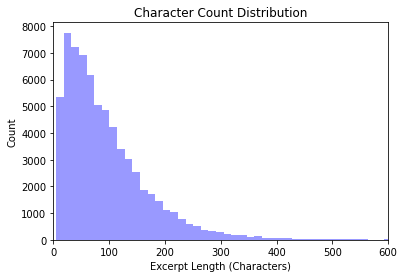

In [4]:
# Plot character count distribution
sns.distplot(char_count, kde = False, bins = 100, color = 'blue').set_title("Character Count Distribution")
plt.xlabel('Excerpt Length (Characters)')
plt.ylabel('Count')
plt.xlim(0, 600)
plt.savefig("char_count.eps")
#print("\nAverage length statistics")
#get_stats(ave_length)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

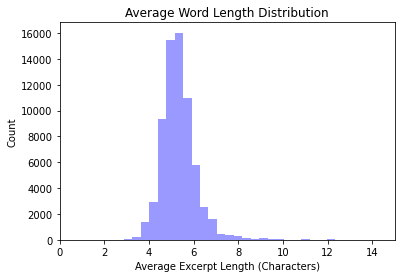

In [5]:
# Plot average excerpt length distribution
sns.distplot(ave_length, kde = False, bins = 70, color = 'blue').set_title("Average Word Length Distribution")
plt.xlabel('Average Excerpt Length (Characters)')
plt.ylabel('Count')
plt.xlim(0, 15)
plt.savefig("ave_length.eps")

The vast majority of text excerpts are under 100 words long, with an average length of around 18 words. However, there are a small number of outliers, including one excerpt containing over 250 words. At the opposite end of the spectrum, 1 percent of the text excerpts contain only 1 word each.

On average, the text excerpts contain around 95 characters each, with the longest containing 1370 characters and the shortest, just 5 characters (sentences containing fewer than 5 characters were removed during the creation of the dataset). We would expect there to be a high correlation between word count and character count, so as a result, we shall just focus on further examining word count outliers, going forward and assume these are the same as the character count outliers.

With regard to word length, the majority of the excerpts have an average word length of around 5.3 characters. However, there are also outliers in this distribution, including one excerpt with an average word length of 22.0 characters, and at the other end of the spectrum, an excerpt with an average word length of 2.5 characters.



In [6]:
#Preprocessing
word_outliers = np.where(word_count > 150)
word_outliers = np.where(word_count < 2)
length_outliers = np.where(ave_length > 10)
length_outliers = np.where(ave_length < 3.5)
text_string = ''
for i in range(len(text)):
    text_string += text[i].lower()
char_cnt = Counter(text_string)
accented_chars = ['ï', 'é', 'ñ', 'è', 'ö', 'æ', 'ô', 'â', 'á', 'à', 'ê', 'ë']
accented_text = []
for i in range(len(text)):
    for j in text[i]:
        if j in accented_chars:
            accented_text.append(i)    
accented_text = list(set(accented_text)) 

In [7]:
# Remove invalid character from text
text = [excerpt.replace('\xa0', '') for excerpt in text]
unusual_text = []

for i in range(len(text)):
    for j in text[i]:
        if j == '\xa0':
            unusual_text.append(i)
        
unusual_text = list(set(unusual_text))
 
print('There are', str(len(unusual_text)), 'texts containing the invalid character.')
new_text = []

for excerpt in text:
    while "  " in excerpt:
        excerpt = excerpt.replace("  "," ")
    new_text.append(excerpt)

text = new_text
ctr = 0
for excerpt in text:
    if "  " in excerpt:
        ctr += 1

print('There are', ctr, 'excerpts containing blocks of white space.')
normed_text = []

for i in range(len(text)):
    new = text[i].lower()
    new = new.translate(str.maketrans('','', string.punctuation))
    new = new.replace('“', '').replace('”', '')
    normed_text.append(new)


There are 0 texts containing the invalid character.
There are 0 excerpts containing blocks of white space.


In [8]:
#Training and Testing
from sklearn.model_selection import train_test_split
text_train, text_test, author_train, author_test = train_test_split(normed_text, author, test_size = 0.2, random_state = 5)

In [9]:
from keras.preprocessing import text
def create_n_grams(excerpt_list, n, vocab_size, seq_size):
    n_gram_list = []
    for excerpt in excerpt_list:
        # Remove spaces
        excerpt = excerpt.replace(" ", "")
        # Extract n-grams
        n_grams = [excerpt[i:i + n] for i in range(len(excerpt) - n + 1)]
        new_string = " ".join(n_grams)
        # One hot encode
        hot = text.one_hot(new_string, round(vocab_size*1.3))
        hot_len = len(hot)
        if hot_len >= seq_size:
            hot = hot[0:seq_size]
        else:
            diff = seq_size - hot_len
            extra = [0]*diff
            hot = hot + extra

        n_gram_list.append(hot)
    
    n_gram_array = np.array(n_gram_list)
    return n_gram_array

In [10]:
def get_vocab_size(excerpt_list, n, seq_size):
    n_gram_list = []
    for excerpt in excerpt_list:
        excerpt = excerpt.replace(" ", "")
        n_grams = [excerpt[i:i + n] for i in range(len(excerpt) - n + 1)]
        gram_len = len(n_grams)
        if gram_len >= seq_size:
            n_grams = n_grams[0:seq_size]
        else:
            diff = seq_size - gram_len
            extra = [0]*diff
            n_grams = n_grams + extra
        
        n_gram_list.append(n_grams)
    
    # Flatten n-gram list
    n_gram_list = list(np.array(n_gram_list).flat)
    n_gram_cnt = Counter(n_gram_list)
    vocab_size = len(n_gram_cnt)
    return vocab_size
for i in range(1, 4):
    vocab_size = get_vocab_size(text_train, i, 350)
    print('Vocab size for n =', i, 'is:', vocab_size)

Vocab size for n = 1 is: 52
Vocab size for n = 2 is: 982
Vocab size for n = 3 is: 9504


In [11]:
# Create n-gram lists
gram1_train = create_n_grams(text_train, 1, 52, 350)
gram2_train = create_n_grams(text_train, 2, 973, 350)
gram3_train = create_n_grams(text_train, 3, 9529, 350)

gram1_test = create_n_grams(text_test, 1, 52, 350)
gram2_test = create_n_grams(text_test, 2, 973, 350)
gram3_test = create_n_grams(text_test, 3, 9529, 350)

max_1gram = np.max(gram1_train)
max_2gram = np.max(gram2_train)
max_3gram = np.max(gram3_train)

In [12]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

def process_data(excerpt_list):
    stop_words = set(stopwords.words('english'))
    porter = PorterStemmer()
    
    processed = []
    
    for excerpt in excerpt_list:
        new = excerpt.split()
        word_list = [porter.stem(w) for w in new if not w in stop_words]
        word_list = " ".join(word_list)
        processed.append(word_list)
    
    return processed
processed_train = process_data(text_train)
processed_test = process_data(text_test)

In [13]:
# Bag of words and one hot
from sklearn import preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(strip_accents = 'ascii', stop_words = 'english', min_df = 6)
vectorizer.fit(processed_train)

# Create feature vectors
words_train = vectorizer.transform(processed_train)
words_test = vectorizer.transform(processed_test)
author_lb = preprocessing.LabelBinarizer()

author_lb.fit(author_train)
author_train_hot = author_lb.transform(author_train)
author_test_hot = author_lb.transform(author_test)

In [15]:
#CNN
def define_model(input_len, output_size, vocab_size, embedding_dim, verbose = True,
                drop_out_pct = 0.25, conv_filters = 500, activation_fn = 'relu', pool_size = 2, learning = 0.0001):
    inputs1 = Input(shape = (input_len,))
    embedding1 = Embedding(vocab_size, embedding_dim)(inputs1)
    drop1 = Dropout(drop_out_pct)(embedding1)
    conv1 = Conv1D(filters = conv_filters, kernel_size = 3, activation = activation_fn)(drop1)
    pool1 = MaxPooling1D(pool_size = pool_size)(conv1)
    flat1 = Flatten()(pool1)

    inputs2 = Input(shape = (input_len,))
    embedding2 = Embedding(vocab_size, embedding_dim)(inputs2)
    drop2 = Dropout(drop_out_pct)(embedding2)
    conv2 = Conv1D(filters = conv_filters, kernel_size = 4, activation = activation_fn)(drop2)
    pool2 = MaxPooling1D(pool_size = pool_size)(conv2)
    flat2 = Flatten()(pool2)

    inputs3 = Input(shape = (input_len,))
    embedding3= Embedding(vocab_size, embedding_dim)(inputs3)
    drop3 = Dropout(drop_out_pct)(embedding3)
    conv3 = Conv1D(filters = conv_filters, kernel_size = 5, activation = activation_fn)(drop3)
    pool3 = MaxPooling1D(pool_size = pool_size)(conv3)
    flat3 = Flatten()(pool3)
    
    merged = concatenate([flat1, flat2, flat3])
    output = Dense(output_size, activation = 'softmax')(merged)
    model = Model(inputs = [inputs1, inputs2, inputs3], outputs = output)
    model.compile(loss='categorical_crossentropy', optimizer = tf.keras.optimizers.Adam(lr = learning), metrics=['accuracy'])
    
    if verbose:
        print(model.summary())
        
    return model

In [16]:
# Create the 1-gram model
gram1_model = define_model(350, 8, max_1gram + 1, 26)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 350)]        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 350)]        0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 350)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 350, 26)      1742        input_1[0][0]                    
______________________________________________________________________________________________

C:\Users\My Pc\AppData\Roaming\Python\Python39\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [17]:
# Train 1-gram CNN
gram1_model.fit([gram1_train, gram1_train, gram1_train], author_train_hot, epochs=5, batch_size=32, 
                verbose = 1, validation_split = 0.2)

Epoch 1/5
1360/1360 [==============================] - 586s 430ms/step - loss: 2.0390 - accuracy: 0.1790 - val_loss: 1.9529 - val_accuracy: 0.2344
Epoch 2/5
1360/1360 [==============================] - 646s 475ms/step - loss: 1.8917 - accuracy: 0.2665 - val_loss: 1.8821 - val_accuracy: 0.2645
Epoch 3/5
1360/1360 [==============================] - 741s 545ms/step - loss: 1.8116 - accuracy: 0.3126 - val_loss: 1.8506 - val_accuracy: 0.2869
Epoch 4/5
1360/1360 [==============================] - 721s 530ms/step - loss: 1.7456 - accuracy: 0.3482 - val_loss: 1.8319 - val_accuracy: 0.2992
Epoch 5/5
1360/1360 [==============================] - 717s 527ms/step - loss: 1.6782 - accuracy: 0.3767 - val_loss: 1.8178 - val_accuracy: 0.3106


In [20]:
# Create the 2-gram model
gram2_model = define_model(350, 8, max_2gram + 1, 300)

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 350)]        0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, 350)]        0                                            
__________________________________________________________________________________________________
input_9 (InputLayer)            [(None, 350)]        0                                            
__________________________________________________________________________________________________
embedding_6 (Embedding)         (None, 350, 300)     378600      input_7[0][0]                    
____________________________________________________________________________________________

In [21]:
# Train 2-gram CNN
gram2_model.fit([gram2_train, gram2_train, gram2_train], author_train_hot, epochs=5, batch_size=32, 
                verbose = 1, validation_split = 0.2)

Epoch 1/5
1360/1360 [==============================] - 2083s 2s/step - loss: 1.9668 - accuracy: 0.2245 - val_loss: 1.7555 - val_accuracy: 0.3410
Epoch 2/5
1360/1360 [==============================] - 2074s 2s/step - loss: 1.5922 - accuracy: 0.4158 - val_loss: 1.5779 - val_accuracy: 0.4200
Epoch 3/5
1360/1360 [==============================] - 2139s 2s/step - loss: 1.3934 - accuracy: 0.5022 - val_loss: 1.5211 - val_accuracy: 0.4417
Epoch 4/5
1360/1360 [==============================] - 2055s 2s/step - loss: 1.2498 - accuracy: 0.5600 - val_loss: 1.4922 - val_accuracy: 0.4599
Epoch 5/5
1360/1360 [==============================] - 2063s 2s/step - loss: 1.1253 - accuracy: 0.6133 - val_loss: 1.4797 - val_accuracy: 0.4699


In [22]:
# Create the 3-gram model
gram3_model = define_model(350, 8, max_3gram + 1, 600)

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 350)]        0                                            
__________________________________________________________________________________________________
input_11 (InputLayer)           [(None, 350)]        0                                            
__________________________________________________________________________________________________
input_12 (InputLayer)           [(None, 350)]        0                                            
__________________________________________________________________________________________________
embedding_9 (Embedding)         (None, 350, 600)     7432800     input_10[0][0]                   
____________________________________________________________________________________________

In [24]:
# Train 3-gram CNN
gram3_model.fit([gram3_train, gram3_train, gram3_train], author_train_hot, epochs=5, batch_size=32, 
                verbose = 1, validation_split = 0.2)

Epoch 1/5
1360/1360 [==============================] - 4193s 3s/step - loss: 0.4907 - accuracy: 0.8500 - val_loss: 1.3215 - val_accuracy: 0.5742
Epoch 2/5
1360/1360 [==============================] - 4191s 3s/step - loss: 0.3798 - accuracy: 0.8917 - val_loss: 1.4069 - val_accuracy: 0.5694
Epoch 3/5
1360/1360 [==============================] - 4194s 3s/step - loss: 0.2878 - accuracy: 0.9227 - val_loss: 1.5317 - val_accuracy: 0.5626
Epoch 4/5
1360/1360 [==============================] - 4190s 3s/step - loss: 0.2167 - accuracy: 0.9452 - val_loss: 1.6768 - val_accuracy: 0.5596
Epoch 5/5
1360/1360 [==============================] - 4001s 3s/step - loss: 0.1631 - accuracy: 0.9605 - val_loss: 1.7597 - val_accuracy: 0.5527


In [25]:
# SVM
svm = SVC()
params = {'kernel': ['linear'], 'C':[1, 10, 100]}
scorer = make_scorer(accuracy_score)

grid_obj = GridSearchCV(svm, params, scoring = scorer, verbose = 50)

In [26]:
# Fit bag of words svm
np.random.seed(6)
word_svm = grid_obj.fit(words_train, author_train)
print(word_svm.best_estimator_)
print(word_svm.cv_results_)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV 1/5; 1/3] START C=1, kernel=linear..........................................
[CV 1/5; 1/3] END ...........C=1, kernel=linear;, score=0.600 total time= 3.1min
[CV 2/5; 1/3] START C=1, kernel=linear..........................................
[CV 2/5; 1/3] END ...........C=1, kernel=linear;, score=0.603 total time= 3.1min
[CV 3/5; 1/3] START C=1, kernel=linear..........................................
[CV 3/5; 1/3] END ...........C=1, kernel=linear;, score=0.600 total time= 3.1min
[CV 4/5; 1/3] START C=1, kernel=linear..........................................
[CV 4/5; 1/3] END ...........C=1, kernel=linear;, score=0.596 total time= 3.1min
[CV 5/5; 1/3] START C=1, kernel=linear..........................................
[CV 5/5; 1/3] END ...........C=1, kernel=linear;, score=0.600 total time= 3.1min
[CV 1/5; 2/3] START C=10, kernel=linear.........................................
[CV 1/5; 2/3] END ..........C=10, kernel=linear;,

In [27]:
def define_model2(input_len, output_size, vocab_size, embedding_dim, verbose = True,
                drop_out_pct = 0.25, conv_filters = 500, activation_fn = 'relu', pool_size = 2, learning = 0.0001):
    # Channel 1
    inputs1 = Input(shape = (input_len,))
    embedding1 = Embedding(vocab_size, embedding_dim)(inputs1)
    drop1 = Dropout(drop_out_pct)(embedding1)
    conv1 = Conv1D(filters = conv_filters, kernel_size = 3, activation = activation_fn)(drop1)
    pool1 = MaxPooling1D(pool_size = pool_size)(conv1)
    flat1 = Flatten()(pool1)
    
    # Channel 2
    inputs2 = Input(shape = (input_len,))
    embedding2 = Embedding(vocab_size, embedding_dim)(inputs2)
    drop2 = Dropout(drop_out_pct)(embedding2)
    conv2 = Conv1D(filters = conv_filters, kernel_size = 4, activation = activation_fn)(drop2)
    pool2 = MaxPooling1D(pool_size = pool_size)(conv2)
    flat2 = Flatten()(pool2)

    # Channel 3
    inputs3 = Input(shape = (input_len,))
    embedding3= Embedding(vocab_size, embedding_dim)(inputs3)
    drop3 = Dropout(drop_out_pct)(embedding3)
    conv3 = Conv1D(filters = conv_filters, kernel_size = 5, activation = activation_fn)(drop3)
    pool3 = MaxPooling1D(pool_size = pool_size)(conv3)
    flat3 = Flatten()(pool3)
    
    # Channel 4
    inputs4 = Input(shape = (input_len,))
    embedding4 = Embedding(vocab_size, embedding_dim)(inputs4)
    drop4 = Dropout(drop_out_pct)(embedding4)
    conv4 = Conv1D(filters = conv_filters, kernel_size = 6, activation = activation_fn)(drop4)
    pool4 = MaxPooling1D(pool_size = pool_size)(conv4)
    flat4 = Flatten()(pool4)
    merged = concatenate([flat1, flat2, flat3, flat4])
    output = Dense(output_size, activation = 'softmax')(merged)
    model = Model(inputs = [inputs1, inputs2, inputs3, inputs4], outputs = output)
    model.compile(loss='categorical_crossentropy', optimizer = Adam(lr = learning), metrics=['accuracy'])
    if verbose:
        print(model.summary())
    return model
# Create the 3-gram model
gram3_model2 = define_model2(350, 8, max_3gram + 1, 600)


Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 350)]        0                                            
__________________________________________________________________________________________________
input_14 (InputLayer)           [(None, 350)]        0                                            
__________________________________________________________________________________________________
input_15 (InputLayer)           [(None, 350)]        0                                            
__________________________________________________________________________________________________
input_16 (InputLayer)           [(None, 350)]        0                                            
____________________________________________________________________________________________

C:\Users\My Pc\AppData\Roaming\Python\Python39\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [28]:
# Train 3-gram CNN
gram3_model2.fit([gram3_train, gram3_train, gram3_train, gram3_train], author_train_hot, epochs=5, batch_size=32, 
                verbose = 1, validation_split = 0.2)

Epoch 1/5
1360/1360 [==============================] - 6853s 5s/step - loss: 1.8802 - accuracy: 0.2708 - val_loss: 1.4922 - val_accuracy: 0.4479
Epoch 2/5
1360/1360 [==============================] - 19589s 14s/step - loss: 1.2129 - accuracy: 0.5717 - val_loss: 1.2394 - val_accuracy: 0.5638
Epoch 3/5
1360/1360 [==============================] - 6753s 5s/step - loss: 0.8974 - accuracy: 0.6926 - val_loss: 1.1993 - val_accuracy: 0.5804
Epoch 4/5
1360/1360 [==============================] - 5815s 4s/step - loss: 0.6950 - accuracy: 0.7713 - val_loss: 1.2250 - val_accuracy: 0.5835
Epoch 5/5
1360/1360 [==============================] - 5816s 4s/step - loss: 0.5309 - accuracy: 0.8349 - val_loss: 1.2985 - val_accuracy: 0.5735


In [32]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)  
    df_cm = pd.DataFrame(cm, index = classes,
                  columns = classes)
    sns.heatmap(df_cm, annot=True, cmap = cmap)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title(title)

C:\Users\My Pc\AppData\Roaming\Python\Python39\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_20 (InputLayer)           [(None, 350)]        0                                            
__________________________________________________________________________________________________
input_21 (InputLayer)           [(None, 350)]        0                                            
__________________________________________________________________________________________________
input_22 (InputLayer)           [(None, 350)]        0                                            
__________________________________________________________________________________________________
embedding_19 (Embedding)        (None, 350, 600)     7432800     input_20[0][0]                   
____________________________________________________________________________________________

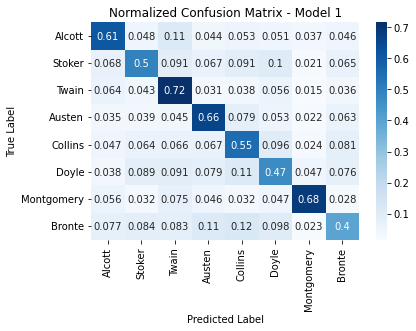

In [34]:
#Model 1 (3-gram CNN)

t0 = time.time()
# Fit model
model1 = define_model(350, 8, max_3gram + 1, 600)
model1.fit([gram3_train, gram3_train, gram3_train], author_train_hot, epochs=5, batch_size=32, 
           verbose = 1, validation_split = 0.2)
t1 = time.time()

# Predict values for test set
author_pred1 = model1.predict([gram3_test, gram3_test, gram3_test])
t2 = time.time()
# Reverse one-hot encoding of labels
author_pred1 = author_lb.inverse_transform(author_pred1)
# Evaluate
accuracy = accuracy_score(author_test, author_pred1)
precision, recall, f1, support = score(author_test, author_pred1)
ave_precision = np.average(precision, weights = support/np.sum(support))
ave_recall = np.average(recall, weights = support/np.sum(support))
ave_f1 = np.average(f1, weights = support/np.sum(support))
confusion = confusion_matrix(author_test, author_pred1, labels = ['Alcott', 'Stoker', 'Twain', 'Austen', 
                                                                  'Collins', 'Doyle', 'Montgomery', 'Bronte'])
    
print("Accuracy:", accuracy)
print("Ave. Precision:", ave_precision)
print("Ave. Recall:", ave_recall)
print("Ave. F1 Score:", ave_f1)
print("Training Time:", (t1 - t0), "seconds")
print("Prediction Time:", (t2 - t1), "seconds")
print("Confusion Matrix:\n", confusion)
plot_confusion_matrix(confusion, classes=['Alcott', 'Stoker', 'Twain', 'Austen', 
                                                                  'Collins', 'Doyle', 'Montgomery', 'Bronte'],\
                      normalize=True, title='Normalized Confusion Matrix - Model 1')

plt.savefig("confusion1.eps")

Accuracy: 0.5973529411764706
Ave. Precision: 0.6070352891247699
Ave. Recall: 0.5973529411764706
Ave. F1 Score: 0.6000545842320824
Training Time: 269.41978192329407 seconds
Prediction Time: 41.967782974243164 seconds
Confusion Matrix:
 [[1060   75   94   73   48  100   82  109]
 [  71 1007   90   85  130  208   22  139]
 [  82   73 1123   47   54  173   52   81]
 [  55   47   37 1112  113  119   33  135]
 [  72  130   62  132  948  222   36  174]
 [  56  145   77  108  149  904   24  161]
 [ 142   73  113   76   36   96 1103   99]
 [  76  139   70  149  153  230   49  867]]
Normalized confusion matrix
[[0.64594759 0.04570384 0.05728215 0.04448507 0.02925046 0.06093845
  0.04996953 0.06642291]
 [0.04052511 0.57477169 0.05136986 0.04851598 0.07420091 0.11872146
  0.01255708 0.0793379 ]
 [0.04866469 0.04332344 0.66646884 0.02789318 0.03204748 0.10267062
  0.03086053 0.04807122]
 [0.03331314 0.0284676  0.02241066 0.67353119 0.06844337 0.07207753
  0.01998789 0.08176863]
 [0.04054054 0.07319

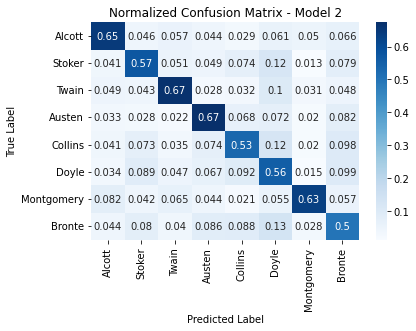

In [33]:
#Model 2 (Bag of words SVM)
np.random.seed(28)
t0 = time.time()
model2 = SVC(C = 1, kernel = 'linear')
model2.fit(words_train, author_train)

t1 = time.time()
author_pred2 = model2.predict(words_test)

t2 = time.time()
accuracy = accuracy_score(author_test, author_pred2)
precision, recall, f1, support = score(author_test, author_pred2)
ave_precision = np.average(precision, weights = support/np.sum(support))
ave_recall = np.average(recall, weights = support/np.sum(support))
ave_f1 = np.average(f1, weights = support/np.sum(support))
confusion = confusion_matrix(author_test, author_pred2, labels =  ['Alcott', 'Stoker', 'Twain', 'Austen', 
                                                                  'Collins', 'Doyle', 'Montgomery', 'Bronte'])
print("Accuracy:", accuracy)
print("Ave. Precision:", ave_precision)
print("Ave. Recall:", ave_recall)
print("Ave. F1 Score:", ave_f1)
print("Training Time:", (t1 - t0), "seconds")
print("Prediction Time:", (t2 - t1), "seconds")
print("Confusion Matrix:\n", confusion)
plot_confusion_matrix(confusion, classes=['Alcott', 'Stoker', 'Twain', 'Austen', 
                                          'Collins', 'Doyle', 'Montgomery', 'Bronte'], \
                      normalize=True, title='Normalized Confusion Matrix - Model 2')

plt.savefig("confusion2.eps")